In [6]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


Predicting future sales (SALE_QTY - Quantity of product sold)
forecast the daily sales for each product and each shop in September 2019

In [82]:
data = pd.read_csv('sales_data_for_test.csv', index_col=0)
data = data.sort_values(by='INVDT', ascending=True)
data = data.set_index('INVDT')
data.head()

WEEK  YEAR  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  NETSALE_VALUE  \
INVDT                                                                      
2019-01-01     1  2019    70      53        65      195.0          195.0   
2019-01-01     1  2019    50      52         1     1099.0         1099.0   
2019-01-01     1  2019    50      52         1     1099.0         1099.0   
2019-01-01     1  2019    50      11         2      178.0          178.0   
2019-01-01     1  2019    35      14         1      299.0          299.0   

            TAX_VALUE  PRODUCT  SHOP  
INVDT                                 
2019-01-01      29.90      147     8  
2019-01-01     167.64      137    97  
2019-01-01     167.64      140   175  
2019-01-01      27.16       91    10  
2019-01-01      14.24       22   220

# 1. Exploratory Data Analysis

How this data was recorded? What's the "primary key" of the dataset 

In [35]:
data.groupby(['WEEK', 'PRODUCT', 'SHOP']).count()

YEAR  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  NETSALE_VALUE  \
WEEK PRODUCT SHOP                                                           
1    0       54       1     1       1         1          1              1   
             70       1     1       1         1          1              1   
             193      1     1       1         1          1              1   
             205      1     1       1         1          1              1   
             228      1     1       1         1          1              1   
             346      1     1       1         1          1              1   
     1       54       1     1       1         1          1              1   
             99       1     1       1         1          1              1   
             119      1     1       1         1          1              1   
             256      1     1       1         1          1              1   
             258      1     1       1         1          1              1   
             283      1     1       1         1          1              1   
             322      1     1       1         1          1              1   
     3       18       1     1       1         1          1              1   
             54       1     1       1         1          1              1   
             61       1     1       1         1          1              1   
             73       1     1       1         1          1              1   
             117      1     1       1         1          1              1   
             119      1     1       1         1          1              1   
             178      1     1       1         1          1              1   
             180      1     1       1         1          1              1   
             192      1     1       1         1          1              1   
             258      1     1       1         1          1              1   
     4       7        1     1       1         1          1              1   
             9        1     1       1         1          1              1   
             18       1     1       1         1          1              1   
             35       1     1       1         1          1              1   
             51       1     1       1         1          1              1   
             76       1     1       1         1          1              1   
             192      1     1       1         1          1              1   
...                 ...   ...     ...       ...        ...            ...   
39   150     224      7     7       7         7          7              7   
             237      6     6       6         6          6              6   
             251      7     7       7         7          7              7   
             259      7     7       7         7          7              7   
             261      7     7       7         7          7              7   
             267      6     6       6         6          6              6   
             269      7     7       7         7          7              7   
             270      7     7       7         7          7              7   
             274      7     7       7         7          7              7   
             278      7     7       7         7          7              7   
             280      7     7       7         7          7              7   
             284      7     7       7         7          7              7   
             287      3     3       3         3          3              3   
             290      6     6       6         6          6              6   
             298      7     7       7         7          7              7   
             300      7     7       7         7          7              7   
             311      5     5       5         5          5              5   
             329      2     2       2         2          2              2   
             330      7     7       7         7          7              7   
             33

Some values are more than 1, so ('WEEK', 'PRODUCT', 'SHOP') is not primary key

Let's get close to the dataset

In [46]:
data[(data['WEEK']==39) & (data['PRODUCT']==150) & (data['SHOP']==224)]

WEEK  YEAR  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  NETSALE_VALUE  \
INVDT                                                                      
2019-09-16    39  2019    70      53        13       65.0            0.0   
2019-09-17    39  2019    70      53        14       70.0            0.0   
2019-09-18    39  2019    70      53         6       30.0            0.0   
2019-09-19    39  2019    70      53         8       40.0            0.0   
2019-09-20    39  2019    70      53         4       20.0            0.0   
2019-09-21    39  2019    70      53         4       20.0            0.0   
2019-09-22    39  2019    70      53        16       80.0            0.0   

            TAX_VALUE  PRODUCT  SHOP  
INVDT                                 
2019-09-16        0.0      150   224  
2019-09-17        0.0      150   224  
2019-09-18        0.0      150   224  
2019-09-19        0.0      150   224  
2019-09-20        0.0      150   224  
2019-09-21        0.0      150   224  
2019-09-22        0.0      150   224

Only one sample per Invoice Date per product per shop is found in dataset. ('INVDT', 'PRODUCT', 'SHOP') is primary key.

In [34]:
data_group= data.groupby(['INVDT', 'PRODUCT', 'SHOP']).count()
data_group

WEEK  YEAR  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  \
INVDT      PRODUCT SHOP                                                  
2019-01-01 0       54       1     1     1       1         1          1   
                   70       1     1     1       1         1          1   
                   193      1     1     1       1         1          1   
                   205      1     1     1       1         1          1   
                   228      1     1     1       1         1          1   
                   346      1     1     1       1         1          1   
           1       54       1     1     1       1         1          1   
                   99       1     1     1       1         1          1   
                   119      1     1     1       1         1          1   
                   256      1     1     1       1         1          1   
                   258      1     1     1       1         1          1   
                   283      1     1     1       1         1          1   
                   322      1     1     1       1         1          1   
           3       18       1     1     1       1         1          1   
                   54       1     1     1       1         1          1   
                   61       1     1     1       1         1          1   
                   73       1     1     1       1         1          1   
                   117      1     1     1       1         1          1   
                   119      1     1     1       1         1          1   
                   178      1     1     1       1         1          1   
                   180      1     1     1       1         1          1   
                   192      1     1     1       1         1          1   
                   258      1     1     1       1         1          1   
           4       7        1     1     1       1         1          1   
                   9        1     1     1       1         1          1   
                   18       1     1     1       1         1          1   
                   35       1     1     1       1         1          1   
                   51       1     1     1       1         1          1   
                   76       1     1     1       1         1          1   
                   192      1     1     1       1         1          1   
...                       ...   ...   ...     ...       ...        ...   
2019-09-22 150     170      1     1     1       1         1          1   
                   195      1     1     1       1         1          1   
                   223      1     1     1       1         1          1   
                   224      1     1     1       1         1          1   
                   237      1     1     1       1         1          1   
                   251      1     1     1       1         1          1   
                   259      1     1     1       1         1          1   
                   261      1     1     1       1         1          1   
                   267      1     1     1       1         1          1   
                   269      1     1     1       1         1          1   
                   270      1     1     1       1         1          1   
                   274      1     1     1       1         1          1   
                   278      1     1     1       1         1          1   
                   280      1     1     1       1         1          1   
                   284      1     1     1       1         1          1   
                   287      1     1     1       1         1          1   
                   290      1     1     1       1         1          1   
                   298      1     1     1       1         1          1   
                   300      1     1     1       1         1          1   
                   330      1     1     1       1         1          1   
                   336      1     1     1       1         1          1   
           151     172      1

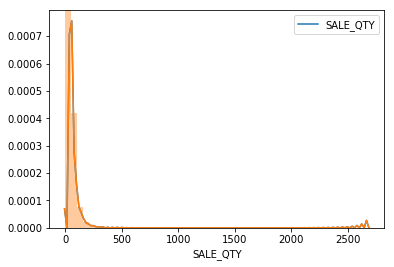

In [3]:
sns.kdeplot(data.SALE_QTY)
sns.distplot(data.SALE_QTY)

It gave a shape of the sales quantity data overall. The SALE_QTY is mostly within the range (0, 500).

## 1.1 Visualize the relation between time and sale_qty

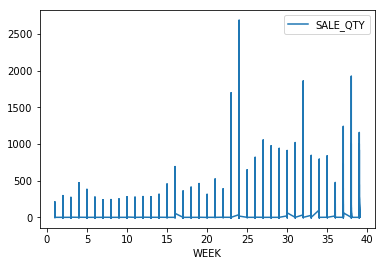

In [4]:
ax = plt.gca()
data.plot(kind='line', x='WEEK', y='SALE_QTY', ax=ax)
plt.show()

## 1.2 Visualize the relation between shop and sale_qty

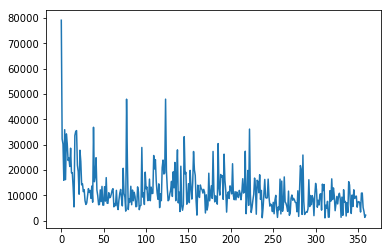

In [11]:
shop_data = data.groupby('SHOP').sum()
plt.figure()
plt.plot(shop_data.index.values, shop_data['SALE_QTY'])
plt.show()

# 2. Data cleaning

## 2.1 Find Outlier

I keep the data with 'MRP_VALUE'=0 or 'NETSALE_VALUE', since the product may give to customers as a gift.

In [25]:
data[(data['MRP_VALUE']==0) | (data['NETSALE_VALUE']==0)]

WEEK  YEAR       INVDT  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  \
636740     1  2019  2019-01-01    35      15         0        0.0   
469739     1  2019  2019-01-01    34       1         0        0.0   
566065     2  2019  2019-01-02    51      51         0        0.0   
655123     2  2019  2019-01-02    35      15         0        0.0   
37817      2  2019  2019-01-02     1       5         0        0.0   
245462     2  2019  2019-01-02    50      11         0        0.0   
719877     2  2019  2019-01-02    50      23         0        0.0   
469356     2  2019  2019-01-03     5      50         0        0.0   
531140     2  2019  2019-01-04    50      11         0        0.0   
717945     2  2019  2019-01-04     7       1         0        0.0   
457172     2  2019  2019-01-05    50      23         0        0.0   
393160     2  2019  2019-01-05    31      10         0        0.0   
712694     2  2019  2019-01-05    51       1         0        0.0   
270954     2  2019  2019-01-05    50      23         0        0.0   
368042     2  2019  2019-01-05    35      14         0        0.0   
515726     2  2019  2019-01-05     7       1         0        0.0   
411356     2  2019  2019-01-06    35       6         0        0.0   
537132     2  2019  2019-01-06    50      22         0        0.0   
253390     3  2019  2019-01-07     5      50         0        0.0   
440008     3  2019  2019-01-07    35       6         0        0.0   
250016     3  2019  2019-01-07    51      51         0        0.0   
198203     3  2019  2019-01-07     1       5         0        0.0   
140384     3  2019  2019-01-07    51      51         0        0.0   
75922      3  2019  2019-01-07    50      52         0        0.0   
68468      3  2019  2019-01-08    35      15         0        0.0   
630499     3  2019  2019-01-08    50      52         0        0.0   
529252     3  2019  2019-01-08    35      14         0        0.0   
297660     3  2019  2019-01-09     1       5         0        0.0   
400154     3  2019  2019-01-11    31      10         0        0.0   
333164     3  2019  2019-01-11    50      21         0        0.0   
...      ...   ...         ...   ...     ...       ...        ...   
663332    39  2019  2019-09-22    70      53        38      114.0   
182604    39  2019  2019-09-22    70      53        39      117.0   
409814    39  2019  2019-09-22    70      53        36      108.0   
630560    39  2019  2019-09-22    70      53        42      126.0   
378260    39  2019  2019-09-22    70      53        59      177.0   
612746    39  2019  2019-09-22    70      53        84      252.0   
149534    39  2019  2019-09-22    70      53       136      408.0   
62719     39  2019  2019-09-22    70      53        20       60.0   
715783    39  2019  2019-09-22    70      53        71      213.0   
377474    39  2019  2019-09-22    70      53        14       42.0   
492970    39  2019  2019-09-22    70      53        38      114.0   
41780     39  2019  2019-09-22    70      53        39      117.0   
254380    39  2019  2019-09-22    70      53        51      153.0   
60675     39  2019  2019-09-22    70      53         8       40.0   
496836    39  2019  2019-09-22    70      53        35      105.0   
187445    39  2019  2019-09-22    70      53        66      198.0   
60128     39  2019  2019-09-22    70      53        44      132.0   
680954    39  2019  2019-09-22    70      53       106      318.0   
143938    39  2019  2019-09-22    70      53        22       66.0   
633401    39  2019  2019-09-22    70      53        40      120.0   
253829    39  2019  2019-09-22    70      53        10       30.0   
41294     39  2019  2019-09-22    70      53        17       85.0   
146222    39  2019  2019-09-22    70      53        98      294.0   
374918    39  2019  2019-09-22    70      53        30       90.0   
61199     39  2019  2019-09-22    70      53        36      108.0   
632346    39  2019  2019-09-22    70      53        37      111.0   
496175

Remove the samples with any of MRP_VALUE, NETSALE_VALUE, TAX_VALUE is negative

Find the sale_qty which is far more away from the normal

In [8]:
filtered_data = data[(data.MRP_VALUE >= 0) & (data.NETSALE_VALUE >= 0) & (data.TAX_VALUE >= 0) & (data.SALE_QTY < 500)]
filtered_data.head()

WEEK  YEAR  MCAT  SUBCAT  SALE_QTY  MRP_VALUE  NETSALE_VALUE  \
INVDT                                                                      
2019-01-01     1  2019    70      53        65      195.0          195.0   
2019-01-01     1  2019    50      52         1     1099.0         1099.0   
2019-01-01     1  2019    50      52         1     1099.0         1099.0   
2019-01-01     1  2019    50      11         2      178.0          178.0   
2019-01-01     1  2019    35      14         1      299.0          299.0   

            TAX_VALUE  PRODUCT  SHOP  
INVDT                                 
2019-01-01      29.90      147     8  
2019-01-01     167.64      137    97  
2019-01-01     167.64      140   175  
2019-01-01      27.16       91    10  
2019-01-01      14.24       22   220

## 2.2 Take care of Missing Data

In [4]:
filtered_data.isnull().values.any()

False

In [5]:
filtered_data.isna().values.any()

False

# 3. Feature engineering

Encoding Categorical Data

onehotencoder = OneHotEncoder(categorical_features=[8,9])
onehot_data = onehotencoder.fit_transform(filtered_data).toarray()
onehot_data.shape

onehot_data_df = pd.DataFrame(onehot_data, index=filtered_data.index)
training_set = onehot_data[onehot_data_df.index < '2019-09-01']
test_set = onehot_data[onehot_data_df.index >= '2019-09-01']
print(training_set.shape, test_set.shape)

## 3.1 Splitting the dataset into Training and Test set

In [17]:
training_set = filtered_data[filtered_data.index < '2019-09-01']
test_set = filtered_data[filtered_data.index >= '2019-09-01']
print(training_set.shape, test_set.shape)

(683286, 10) (56130, 10)


## 3.2 Selecting features

In [19]:
training_set_selected = training_set.iloc[:,2:10]
test_set_selected = test_set.iloc[:,2:10]
training_set_selected.head()

MCAT  SUBCAT  SALE_QTY  MRP_VALUE  NETSALE_VALUE  TAX_VALUE  \
INVDT                                                                     
2019-01-01    70      53        65      195.0          195.0      29.90   
2019-01-01    50      52         1     1099.0         1099.0     167.64   
2019-01-01    50      52         1     1099.0         1099.0     167.64   
2019-01-01    50      11         2      178.0          178.0      27.16   
2019-01-01    35      14         1      299.0          299.0      14.24   

            PRODUCT  SHOP  
INVDT                      
2019-01-01      147     8  
2019-01-01      137    97  
2019-01-01      140   175  
2019-01-01       91    10  
2019-01-01       22   220

## 3.3 Feature Scaling

In [28]:
# normalize features
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set_selected.values)
test_set_scaled = sc.transform(test_set_selected.values)
training_set_scaled

array([[1.        , 0.74285714, 0.13078471, ..., 0.00656083, 0.96710526,
        0.02228412],
       [0.71014493, 0.72857143, 0.00201207, ..., 0.03678453, 0.90131579,
        0.27019499],
       [0.71014493, 0.72857143, 0.00201207, ..., 0.03678453, 0.92105263,
        0.48746518],
       ...,
       [0.47826087, 0.15714286, 0.00201207, ..., 0.00218987, 0.09210526,
        0.52089136],
       [0.71014493, 0.28571429, 0.00201207, ..., 0.00331333, 0.73026316,
        0.82729805],
       [0.71014493, 0.28571429, 0.00603622, ..., 0.00692508, 0.70394737,
        0.46796657]])

In [29]:
training_set_scaled[0]

array([1.        , 0.74285714, 0.13078471, 0.00163169, 0.00203751,
       0.00656083, 0.96710526, 0.02228412])

## 3.4 Splitting features and labels

In [64]:
training_set_scaled_X = training_set_scaled[:,[0,1,2,3,4,5,6,7]]
training_set_scaled_y = training_set_scaled[:,[2]]
test_set_scaled_X = test_set_scaled[:,[0,1,2,3,4,5,6,7]]
test_set_scaled_y = test_set_scaled[:,[2]]

In [31]:
training_set_scaled_X[0]

array([1.        , 0.74285714, 0.00163169, 0.00203751, 0.00656083,
       0.96710526, 0.02228412])

## 3.5 Creating a data structure with 7 timesteps and 1 output

In [77]:
i=7
np.array([training_set_scaled_X[i],]*7).shape
training_set_scaled_y[i-7:i].shape
np.concatenate((np.array([training_set_scaled_X[i],]*7), training_set_scaled_y[i-7:i]),axis = 1).shape

(7, 9)

In [78]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(7, 683286):
    X_train.append(np.concatenate((np.array([training_set_scaled_X[i],]*7), training_set_scaled_y[i-7:i]),axis = 1)) 
    y_train.append(training_set_scaled_y[i])
    
for i in range(7, 56130):
    X_test.append(np.concatenate((np.array([test_set_scaled_X[i],]*7), test_set_scaled_y[i-7:i]),axis = 1))
    y_test.append(test_set_scaled_y[i])
    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(683279, 7, 9) (683279, 1) (56123, 7, 9) (56123, 1)


# 4. Forecast modeling
1. Stacked LSTM
2. With some dropout to prevent overfitting   

In [ ]:
regressor = Sequential() #Sequence of the layers
# units: the number of neurons
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 7))) #input layer
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True)) # hidden layer
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True)) # hidden layer
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=False)) # hidden layer
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1)) #output layer

#compile
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#fitting the rnn with training set
regressor.fit(X_train, y_train, epochs = 5)

#Save model
regressor.save('regressor_model.h5', overwrite=True)

Epoch 1/5
650688/683226 [===========================>..] - ETA: 8:45 - loss: 0.0012

# 5. Evaluate the models

In [ ]:
#predict
predicted_sales_qty= regressor.predict(X_test)

# Scaling Back
pred_arr = test_set_scaled[7:]
predicted_sales_qty = predicted_sales_qty.reshape(56123)
pred_arr[:,2] = predicted_sales_qty
predicted_df = sc.inverse_transform(pred_arr)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, predicted_sales_qty))
rmse_actual = sqrt(mean_squared_error(test_set.iloc[7:,2].values, predicted_df[:,2]))

predicted_df_2 = pd.DataFrame(predicted_df)
predicted_df_2.columns = ['MCAT', 'SUBCAT', 'SALE_QTY', 'MRP_VALUE', 'NETSALE_VALUE', 'TAX_VALUE',	'PRODUCT', 'SHOP']

product_df = predicted_df_2.groupby('PRODUCT').sum()
product_df_actual = test_set.iloc[7:,].groupby('PRODUCT').sum()
product_rmse = sqrt(mean_squared_error(product_df_actual['SALE_QTY'].values, product_df['SALE_QTY'].values))

subcat_df = predicted_df_2.groupby('SUBCAT').sum()
subcat_df_actual = test_set.iloc[7:,].groupby('SUBCAT').sum()
subcat_rmse = sqrt(mean_squared_error(subcat_df_actual['SALE_QTY'].values, subcat_df['SALE_QTY'].values))

mcat_df = predicted_df_2.groupby('MCAT').sum()
mcat_df_actual = test_set.iloc[7:,].groupby('MCAT').sum()
mcat_rmse = sqrt(mean_squared_error(mcat_df_actual['SALE_QTY'].values, mcat_df['SALE_QTY'].values))